In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from ad99 import AlexanderDunkerton1999
from constants import GRAV,R_DRY,C_P

In [2]:
ad99 = AlexanderDunkerton1999(source_level_height=9e3,damp_top=True,dc=0.1,cmax=100)

In [3]:
ds = xr.open_dataset('data/atmos_daily.nc')
ds_mask_trop = xr.open_dataset('data/loon_masks.nc')
ds_mask_trop['lon'] = (ds_mask_trop.lon + 360) % 360 
ds_mask_trop = ds_mask_trop.sortby('lon')
interp_mask = ds_mask_trop.interp(lat=ds.lat,lon=ds.lon,method='nearest').astype(bool)




In [4]:
comb_mask = interp_mask.tropical_atlantic + interp_mask.tropical_pacific + interp_mask.extratropical_atlantic + interp_mask.extratropical_pacific + interp_mask.southern_ocean + interp_mask.indian

/Users/robcking/miniconda3/envs/loon_gw/lib/python3.12/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/robcking/miniconda3/envs/loon_gw/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/robcking/miniconda3/envs/loon_gw/lib/python3.12/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/robcking/miniconda3/envs/loon_gw/lib/python3.12/site-packages/shapely/predicates.py:778: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/robcking/miniconda3/envs/loon_gw/lib/python3.12/site-packages/shapely/constructive.py:180: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/robcking/miniconda3/envs/loon_gw/lib/python3.12/site-packages/shapely/predicates.py:778: Runtime

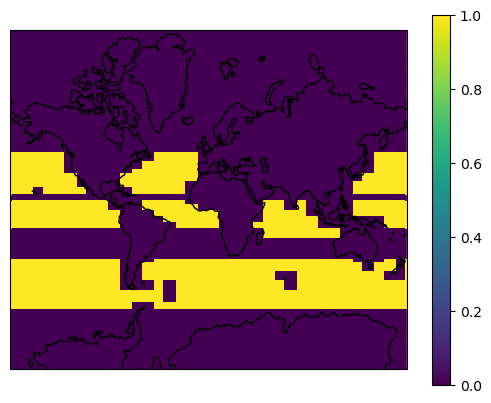

In [5]:
import cartopy.crs as ccrs

ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()
comb_mask.plot.pcolormesh(ax=ax,transform=ccrs.PlateCarree())

In [6]:
ocean_expac = ds.where(comb_mask).stack(points = ['lat','lon'])
ocean_expac = ocean_expac.dropna('points',how='all')
ocean_expac = ocean_expac.isel(pfull=slice(None,None,-1))

ocean_expac = ocean_expac[['ucomp','temp','vcomp','height','gwfu_cgwd','gwfv_cgwd']]
ocean_expac = ocean_expac.transpose('time','points','pfull')

dTdz = np.gradient(ocean_expac.temp,axis=-1)/np.gradient(ocean_expac.height,axis=-1)
Ns2 = GRAV/ocean_expac.temp*(dTdz + GRAV/C_P) 
bflim = 1e-4 
Ns2 = xr.where(Ns2 < bflim**2,bflim**2,Ns2)
Ns = np.sqrt(Ns2)
rho = (100*ocean_expac.pfull.data[None,None,:])/(R_DRY*ocean_expac.temp)

In [7]:
u = ocean_expac.ucomp.data
Ns = Ns.data
rho = rho.data
z = ocean_expac.height.data


In [8]:
from joblib import Parallel, delayed
from tqdm.notebook import tqdm 
gwd = np.zeros_like(u)
uw_ptv = np.zeros_like(u)
uw_ntv = np.zeros_like(u)

def get_ad99(i,j,ad99):
    gwd = ad99.gwd(u[i,j],Ns[i,j],z[i,j],rho[i,j])
    uw_ptv = ad99.gwd_momentum_flux_ptv(gwd,z[i,j],rho[i,j])
    uw_ntv = ad99.gwd_momentum_flux_ntv(gwd,z[i,j],rho[i,j])
    return i,j,gwd,uw_ptv,uw_ntv


results = Parallel(n_jobs=-1)(delayed(get_ad99)(i,j,ad99) for i in range(u.shape[0]) for j in range(u.shape[1]))

for i,j,gwd_val,uw_ptv_val,uw_ntv_val in results:
    gwd[i,j] = gwd_val
    uw_ptv[i,j] = uw_ptv_val
    uw_ntv[i,j] = uw_ntv_val

In [9]:
u_noise = u + np.random.standard_normal(u.shape)*np.std(u,axis=-1,keepdims=True)*5

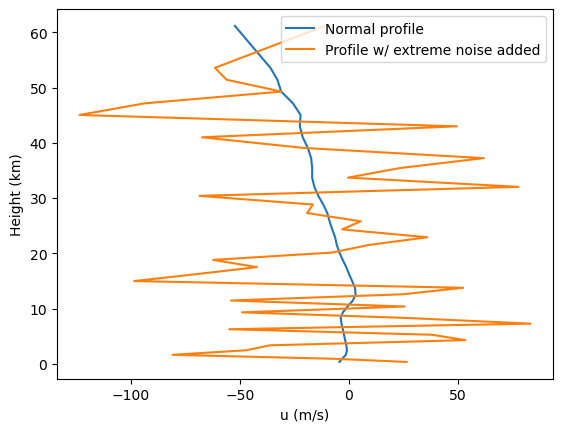

In [27]:
plt.plot(u[0,0],z[0,0]/1000,label='Normal profile')
plt.plot(u_noise[0,0],z[0,0]/1000,label='Profile w/ extreme noise added')
plt.xlabel("u (m/s)")
plt.ylabel("Height (km)")
plt.legend()

In [11]:
gwd_noise= np.zeros_like(u)
uw_ptv_noise = np.zeros_like(u)
uw_ntv_noise = np.zeros_like(u)

def get_ad99(i,j,ad99):
    gwd = ad99.gwd(u_noise[i,j],Ns[i,j],z[i,j],rho[i,j])
    uw_ptv = ad99.gwd_momentum_flux_ptv(gwd,z[i,j],rho[i,j])
    uw_ntv = ad99.gwd_momentum_flux_ntv(gwd,z[i,j],rho[i,j])
    return i,j,gwd,uw_ptv,uw_ntv

results = Parallel(n_jobs=-1)(delayed(get_ad99)(i,j,ad99) for i in range(u.shape[0]) for j in range(u.shape[1]))

for i,j,gwd_val,uw_ptv_val,uw_ntv_val in results:
    gwd_noise[i,j] = gwd_val
    uw_ptv_noise[i,j] = uw_ptv_val
    uw_ntv_noise[i,j] = uw_ntv_val

In [29]:
from scipy.interpolate import make_interp_spline
new_coords = np.arange(0,39.25,0.25)
old_coords = np.arange(0,40,1)
interp_pressure = np.exp(np.interp(new_coords,old_coords,np.log(ocean_expac.pfull)))
u_spl = make_interp_spline(old_coords,u,axis=-1,k=3)
u_noise_spl = make_interp_spline(old_coords,u_noise,axis=-1,k=3)
z_spl = make_interp_spline(old_coords,z,axis=-1,k=3)
rho_spl = make_interp_spline(old_coords,rho,axis=-1,k=3) 
Ns_spl = make_interp_spline(old_coords,Ns,axis=-1,k=3)   

In [30]:
u_interp = u_spl(new_coords)
u_interp_noise = u_noise_spl(new_coords)
z_interp = z_spl(new_coords)
rho_interp = rho_spl(new_coords)
Ns_interp = Ns_spl(new_coords)

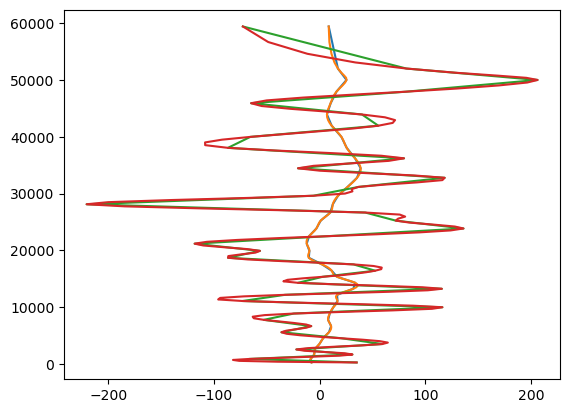

In [31]:
# plt.plot(u[0,0],z[0,0])
# plt.plot(u_noise[0,0],z[0,0])
plt.plot(u[0,0],z[0,0])
plt.plot(u_interp[0,0],z_interp[0,0])
plt.plot(u_noise[0,0],z[0,0])
plt.plot(u_interp_noise[0,0],z_interp[0,0])

In [32]:

gwd_interp= np.zeros_like(u_interp)
uw_ptv_interp = np.zeros_like(u_interp)
uw_ntv_interp = np.zeros_like(u_interp)

def get_ad99(i,j,ad99):
    gwd = ad99.gwd(u_interp[i,j],Ns_interp[i,j],z_interp[i,j],rho_interp[i,j])
    uw_ptv = ad99.gwd_momentum_flux_ptv(gwd,z_interp[i,j],rho_interp[i,j])
    uw_ntv = ad99.gwd_momentum_flux_ntv(gwd,z_interp[i,j],rho_interp[i,j])
    return i,j,gwd,uw_ptv,uw_ntv

results = Parallel(n_jobs=-1)(delayed(get_ad99)(i,j,ad99) for i in range(u_interp.shape[0]) for j in range(u_interp.shape[1]))

for i,j,gwd_val,uw_ptv_val,uw_ntv_val in results:
    gwd_interp[i,j] = gwd_val
    uw_ptv_interp[i,j] = uw_ptv_val
    uw_ntv_interp[i,j] = uw_ntv_val

In [33]:

gwd_interp_noise= np.zeros_like(u_interp_noise)
uw_ptv_interp_noise = np.zeros_like(u_interp_noise)
uw_ntv_interp_noise = np.zeros_like(u_interp_noise)

def get_ad99(i,j,ad99):
    gwd = ad99.gwd(u_interp_noise[i,j],Ns_interp[i,j],z_interp[i,j],rho_interp[i,j])
    uw_ptv = ad99.gwd_momentum_flux_ptv(gwd,z_interp[i,j],rho_interp[i,j])
    uw_ntv = ad99.gwd_momentum_flux_ntv(gwd,z_interp[i,j],rho_interp[i,j])
    return i,j,gwd,uw_ptv,uw_ntv

results = Parallel(n_jobs=-1)(delayed(get_ad99)(i,j,ad99) for i in range(u_interp.shape[0]) for j in range(u_interp.shape[1]))

for i,j,gwd_val,uw_ptv_val,uw_ntv_val in results:
    gwd_interp_noise[i,j] = gwd_val
    uw_ptv_interp_noise[i,j] = uw_ptv_val
    uw_ntv_interp_noise[i,j] = uw_ntv_val

In [13]:
p_target = 10
i_near = np.abs(np.argmin(np.abs(ocean_expac.pfull.data - p_target)))

near_top_nonoise = uw_ptv[...,i_near].ravel()
near_top_noise = uw_ptv_noise[...,i_near].ravel()
near_top_noise = near_top_noise[near_top_noise > 0]
near_top_nonoise = near_top_nonoise[near_top_nonoise > 0]

In [35]:
i_near_interp = np.abs(np.argmin(np.abs(interp_pressure - p_target)))
near_top_interp = uw_ptv_interp[...,i_near_interp].ravel()
near_top_interp = near_top_interp[near_top_interp > 0]
near_top_interp_noise = uw_ptv_interp_noise[...,i_near_interp].ravel()
near_top_interp_noise = near_top_interp_noise[near_top_interp_noise > 0]

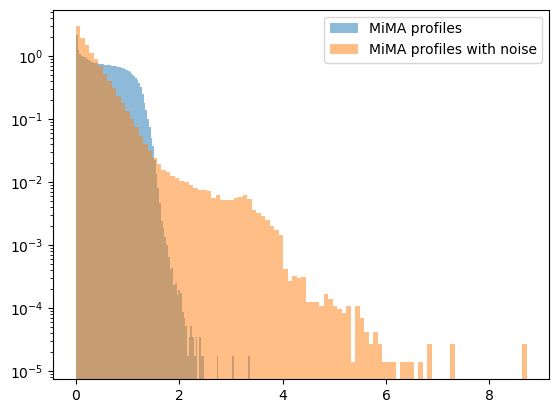

In [15]:
plt.hist(near_top_nonoise*1000,bins=100,alpha=0.5,density=True,label='MiMA profiles')   
plt.hist(near_top_noise*1000,bins=100,alpha=0.5,density=True,label='MiMA profiles with noise')
# plt.hist(near_top_interp*1000,bins=100,alpha=0.5,density=True)
# plt.hist(near_top_interp_noise*1000,bins=100,alpha=0.5,density=True)
plt.yscale('log')
plt.legend()

In [ ]:

Ns

array([[[5.93869342e-03, 1.11096241e-02, 1.29601173e-02, ...,
         1.33458348e-02, 1.28538851e-02, 1.55815678e-02],
        [5.01044653e-03, 1.05263768e-02, 1.29830129e-02, ...,
         1.36984931e-02, 1.25412410e-02, 1.50768068e-02],
        [3.63712828e-03, 1.02016805e-02, 1.32115781e-02, ...,
         1.51171535e-02, 1.24279652e-02, 1.42712686e-02],
        ...,
        [5.23414090e-03, 8.46534222e-03, 1.19224014e-02, ...,
         1.78107247e-02, 1.56772863e-02, 1.63994599e-02],
        [4.89981519e-03, 8.92173126e-03, 1.29089002e-02, ...,
         1.77523643e-02, 1.57075562e-02, 1.65711958e-02],
        [5.23870857e-03, 9.72020719e-03, 1.39462696e-02, ...,
         1.76599398e-02, 1.58042796e-02, 1.68059766e-02]],

       [[2.87083955e-03, 1.01326657e-02, 1.31089576e-02, ...,
         1.73390321e-02, 1.24534704e-02, 1.30016217e-02],
        [3.53237125e-03, 1.02342591e-02, 1.31693268e-02, ...,
         1.74290501e-02, 1.24870446e-02, 1.30464816e-02],
        [3.88164003e-03, 

Text(0.5, 0, 'Log 10 GW momentum flux (mPa)')

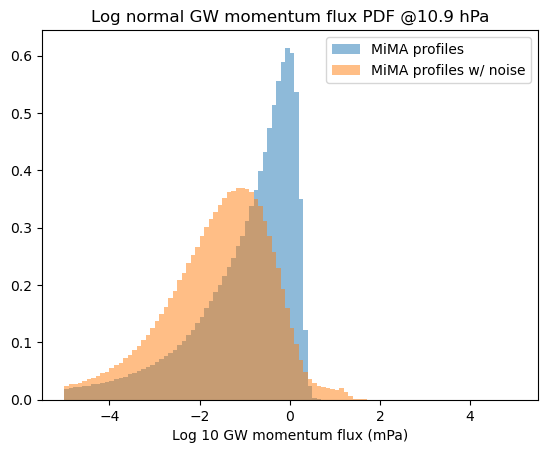

In [21]:
plt.title(f"Log normal GW momentum flux PDF @{ocean_expac.pfull[i_near].values:.1f} hPa")
plt.hist(np.log(1000*near_top_nonoise),bins=np.arange(-5, 5+0.1, 0.1),alpha=0.5,label='MiMA profiles',density=True)   
plt.hist(np.log(1000*near_top_noise),bins=np.arange(-5, 5+0.1, 0.1),alpha=0.5,label='MiMA profiles w/ noise',density=True)
# plt.hist(np.log(1000*near_top_interp),bins=np.arange(-5, 5+0.1, 0.1),alpha=0.5,label='No noise interp')
# plt.hist(np.log(1000*near_top_interp_noise),bins=np.arange(-5, 5+0.1, 0.1),alpha=0.5,label='Noise interp')
plt.legend()
plt.xlabel("Log 10 GW momentum flux (mPa)")